In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
import seaborn as sns
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings
from utils import *

In [2]:
from torch import cuda
device = 'cuda:1' if cuda.is_available() else 'cpu'

In [3]:
data_raw = pd.read_csv("Data_MachineLearning/df_reduced.csv")
data_raw.shape

(7443, 6)

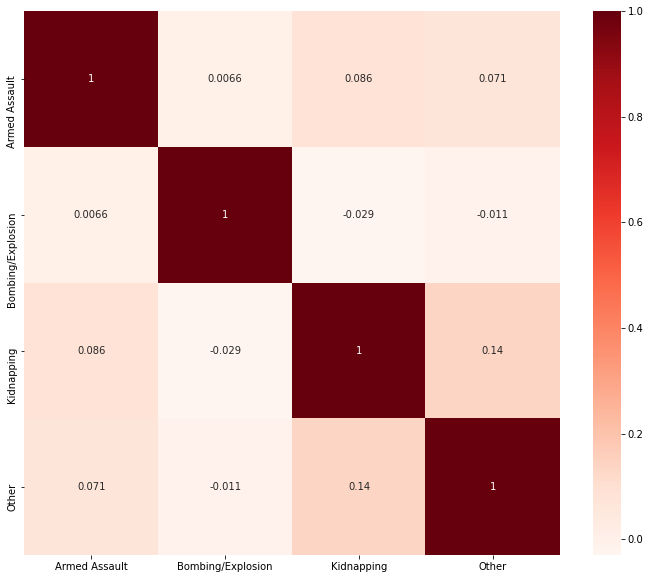

In [4]:
plt.figure(figsize=(12,10))
cor = data_raw.iloc[:,2:].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
categories = list(data_raw.columns.values)
categories = categories[1:]
print(categories)

['is_relevant', 'Armed Assault', 'Bombing/Explosion', 'Kidnapping', 'Other']


In [6]:
counts = []
for category in categories:
    counts.append((category, data_raw[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,is_relevant,1550
1,Armed Assault,659
2,Bombing/Explosion,579
3,Kidnapping,140
4,Other,382


In [7]:
data_raw

,news,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,Two Lashkar e Jhangvi LeJ militants Asim alias...,True,True,False,False,False
1,The Commander Southern Command Lieutenant Gene...,True,False,False,False,True
2,Meanwhile the underground organization Manipur...,True,False,True,False,False
3,Islamic State IS in the latest issue of its on...,True,True,False,False,False
4,A senior Muttahida Qaumi Movement MQM worker i...,True,False,False,False,True
...,...,...,...,...,...,...
7438,Clashes between demonstrators and Police leave...,False,False,False,False,False
7439,The death toll in the ongoing clashes between ...,False,False,False,False,False
7440,An unnamed security official revealed that Fro...,False,False,False,False,False
7441,Police said that militants hurled a grenade on...,True,False,True,False,False


In [8]:
categories

['is_relevant', 'Armed Assault', 'Bombing/Explosion', 'Kidnapping', 'Other']

/home/yibo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


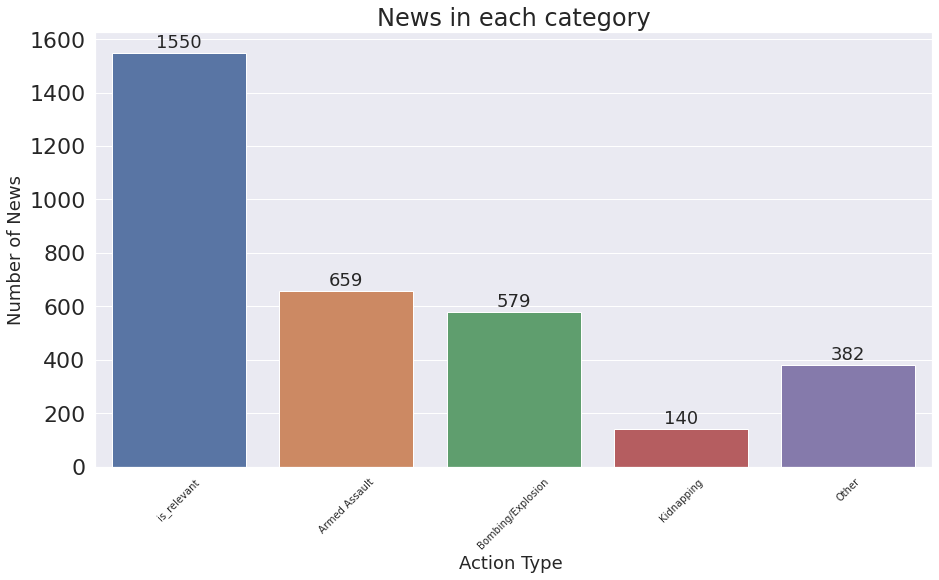

In [9]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, data_raw.iloc[:,1:].sum().values)

plt.title("News in each category", fontsize=24)
plt.ylabel('Number of News', fontsize=18)
plt.xlabel('Action Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, 
            height + 5, label, ha='center', va='bottom', fontsize=18)

plt.xticks(rotation=45, fontsize=10)
    
plt.show()


/home/yibo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


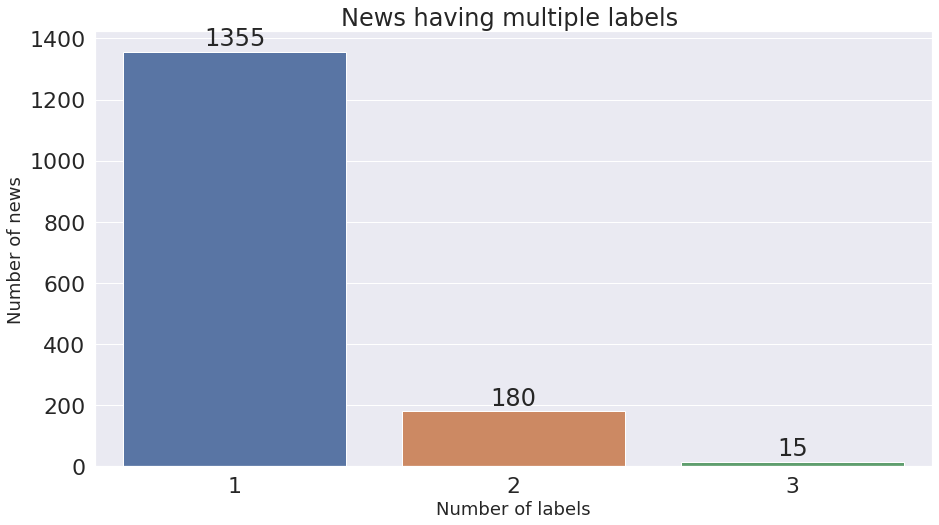

In [10]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("News having multiple labels ")
plt.ylabel('Number of news', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## 1.2 WordCloud representation of most used words in each category of comments

In [11]:
from wordcloud import WordCloud,STOPWORDS

cloud_list = []

for i, col in enumerate(data_raw.columns[1:]):

    subset = data_raw[data_raw[col]==True]
    text = subset.news.values
    cloud = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='black',
                              collocations=False,
                              width=2500,
                              height=1800
                             ).generate(" ".join(text))
    
    cloud_list.append(cloud)

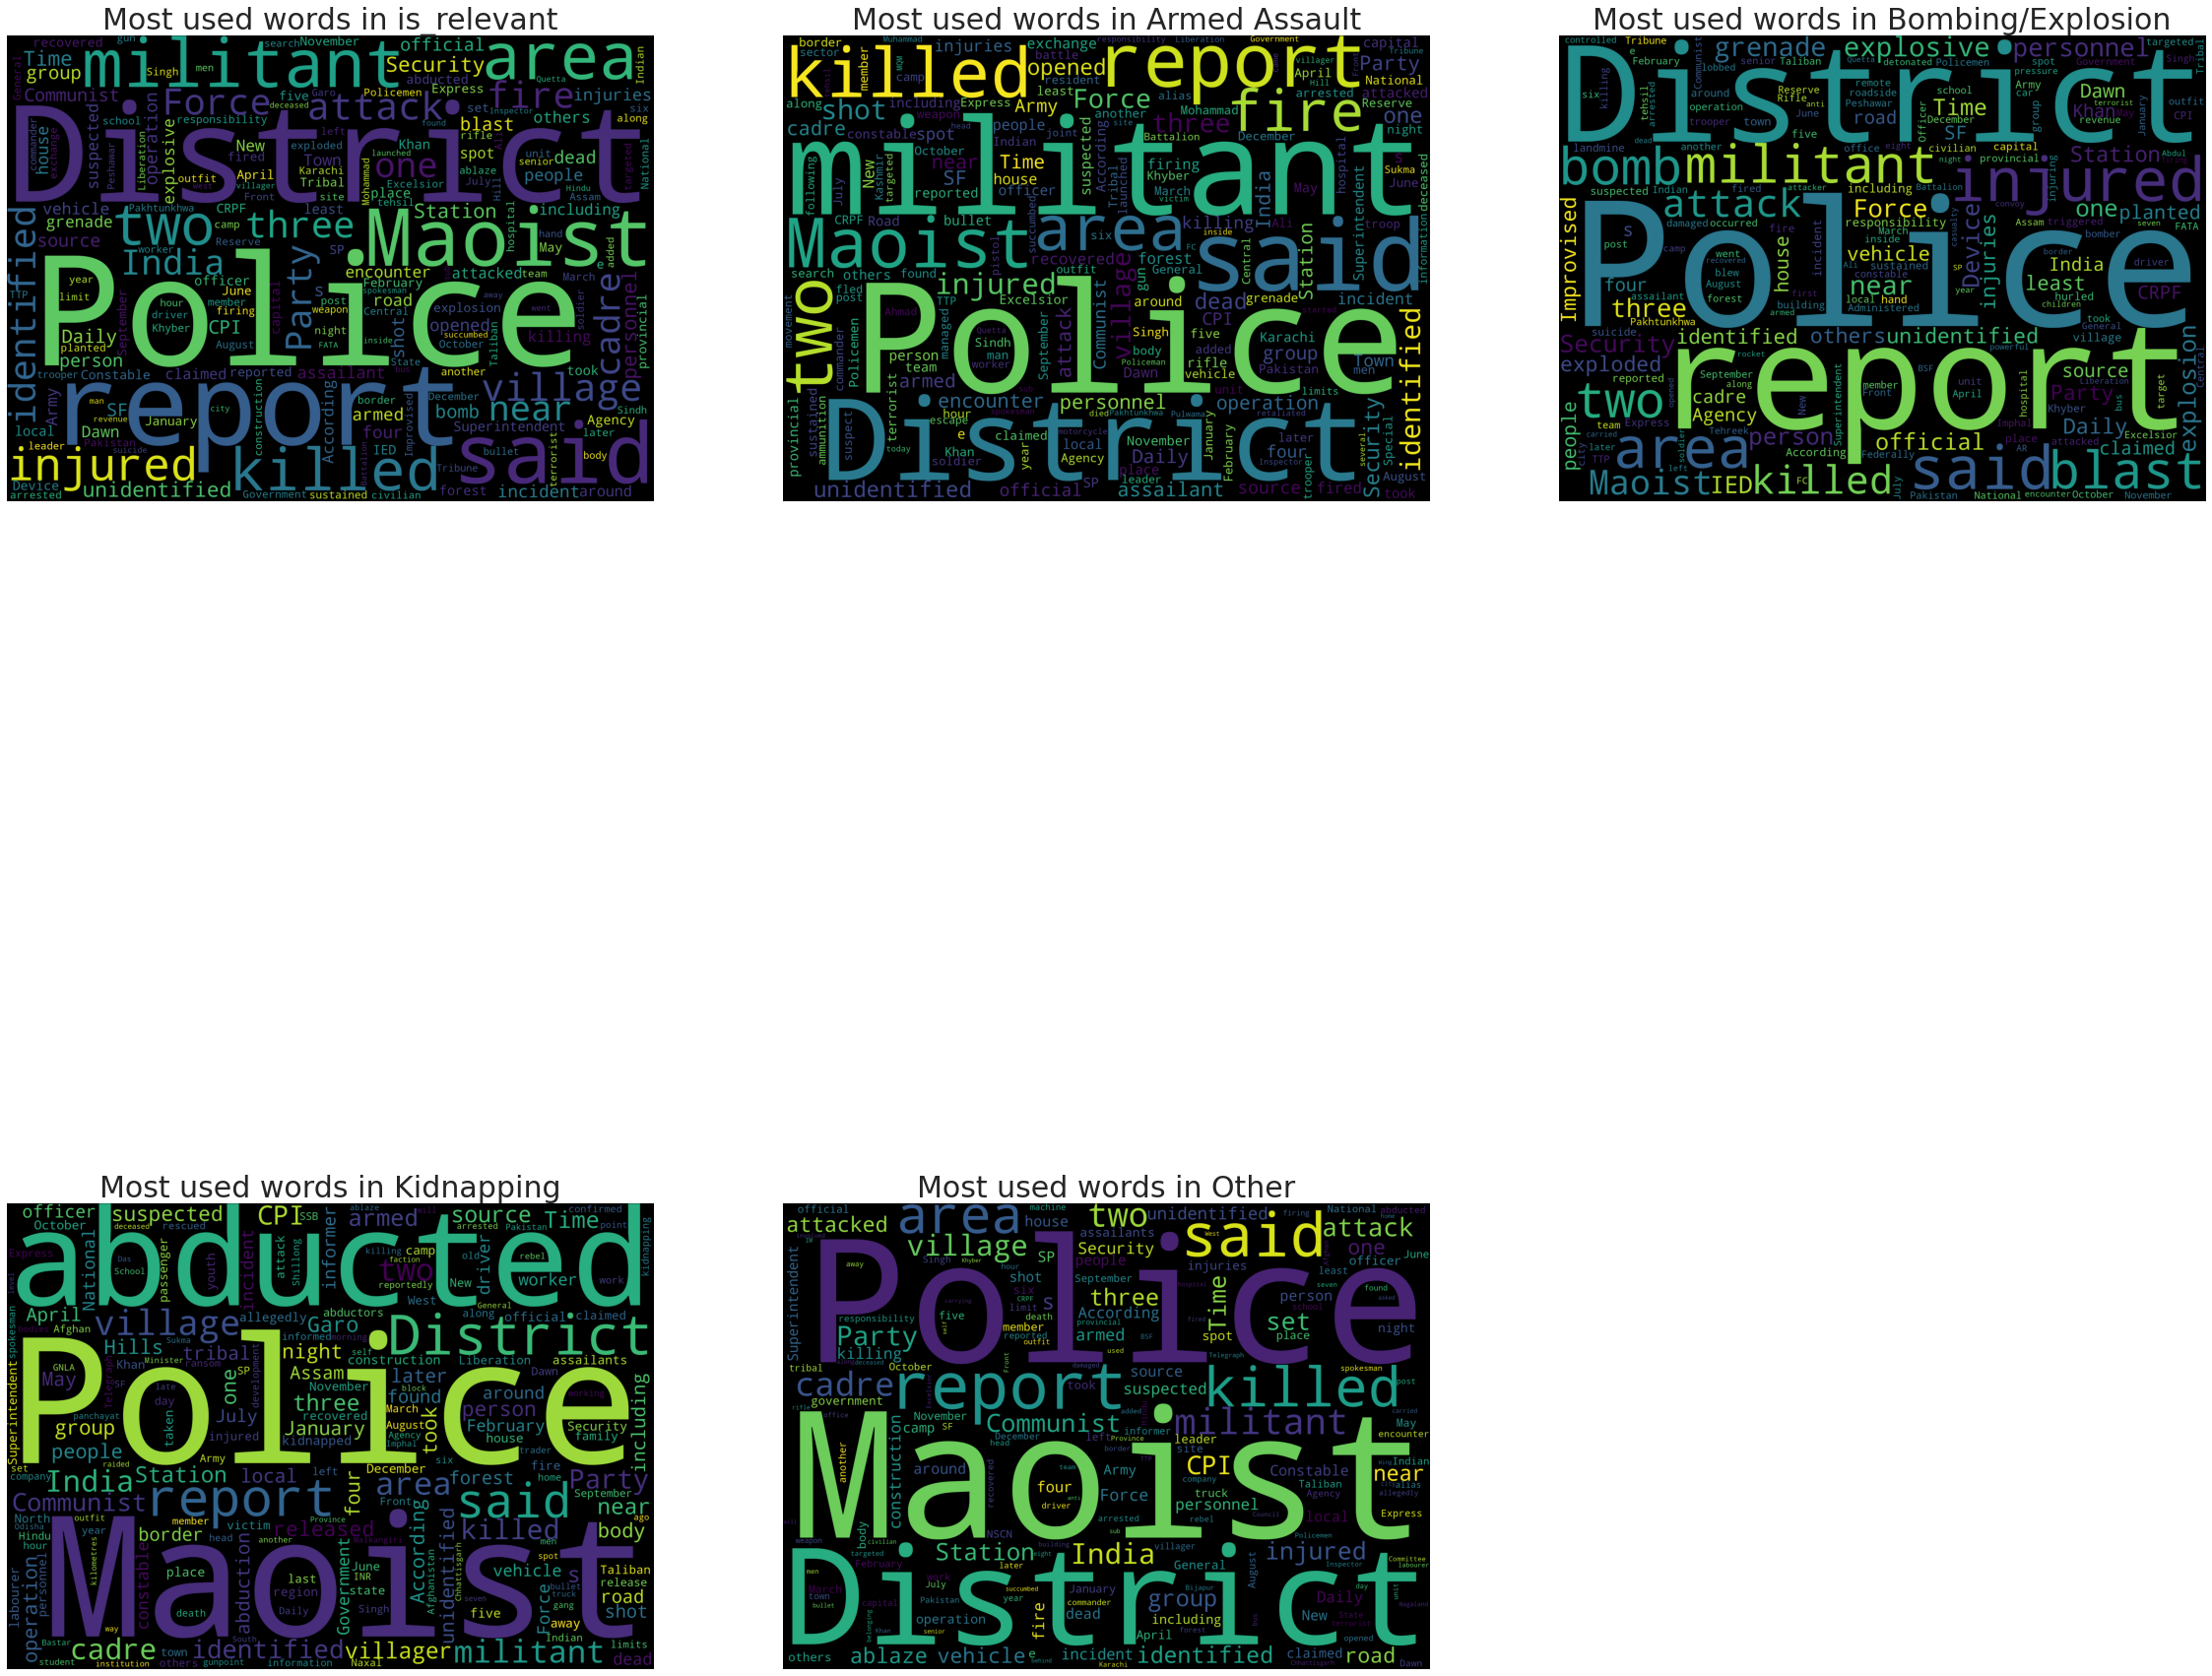

In [12]:
plt.figure(figsize=(40,40))

for i, col in enumerate(data_raw.columns[1:]):
    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.title('Most used words in %s'%col,fontsize=30)
    plt.imshow(cloud_list[i])

plt.show()

# 2. Data Pre-Processing

In [13]:
data = data_raw.copy()

## 2.1. Cleaning Data

In [14]:
def cleanHtml(sentence):  # remove html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


def cleanPunc(sentence): # clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):  # Remove non-alphabetic characters
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [15]:
for i in range(50):
    print (data['news'][i])

Two Lashkar e Jhangvi LeJ militants Asim alias Kapri and Ishaq alias Bobby confessed to killing four Rangers in Ittehad Town of Karachi the provincial capital of Sindh reports The News on December 6 The militants while recording their confessional statements under Section 164 of the Criminal Procedure Code told the Judicial Magistrate West that they had killed four Rangers in Ittehad Town They also admitted they had gunned down two Military Police personnel near the Saddar Parking Plaza on July 19
The Commander Southern Command Lieutenant General Amir Riaz on December 20 said that 700 personnel of the Security Forces SFs have been killed while fighting for the “stability of the country” reports Dawn Riaz added that around 2 000 personnel were also wounded in the province The commander was speaking at a function organized at the Frontier Corps Headquarters in Quetta “For the last 10 to 12 years FC personnel have been fighting against the enemies of Pakistan ” said the senior officer “Yo

In [16]:
data['news'] = data['news'].str.lower()
data['news'] = data['news'].apply(cleanHtml)
data['news'] = data['news'].apply(cleanPunc)
data['news'] = data['news'].apply(keepAlpha)


for i in range(50):
    print (data['news'][i])

two lashkar e jhangvi lej militants asim alias kapri and ishaq alias bobby confessed to killing four rangers in ittehad town of karachi the provincial capital of sindh reports the news on december   the militants while recording their confessional statements under section   of the criminal procedure code told the judicial magistrate west that they had killed four rangers in ittehad town they also admitted they had gunned down two military police personnel near the saddar parking plaza on july
the commander southern command lieutenant general amir riaz on december   said that   personnel of the security forces sfs have been killed while fighting for the  stability of the country  reports dawn riaz added that around     personnel were also wounded in the province the commander was speaking at a function organized at the frontier corps headquarters in quetta  for the last   to   years fc personnel have been fighting against the enemies of pakistan   said the senior officer  you stood firm

 ## 2.2 Remove stop words

In [17]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['news'] = data['news'].apply(removeStopWords)
# data.head()
for i in range(50):
    print (data['news'][i])

 lashkar e jhangvi lej militants asim alias kapri  ishaq alias bobby confessed  killing  rangers  ittehad town  karachi  provincial capital  sindh reports  news  december    militants  recording  confessional statements  section     criminal procedure code told  judicial magistrate west    killed  rangers  ittehad town   admitted   gunned   military police personnel near  saddar parking plaza  july
 commander southern command lieutenant general amir riaz  december   said    personnel   security forces sfs   killed  fighting    stability   country  reports dawn riaz added  around     personnel   wounded   province  commander  speaking   function organized   frontier corps headquarters  quetta    last      years fc personnel   fighting   enemies  pakistan   said  senior officer   stood firm  defeated  enemy   riaz added   elements  geneva dubai  london  behind acts  terrorism   involved   killing  innocent civilians  balochistan  balochistan  part  pakistan   always remain    reiterated 

 ## 2.3. Stemming

In [18]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

data['news'] = data['news'].apply(stemming)

for i in range(50):
    print (data['news'][i])

lashkar e jhangvi lej milit asim alia kapri ishaq alia bobbi confess kill ranger ittehad town karachi provinci capit sindh report news decemb milit record confession statement section crimin procedur code told judici magistr west kill ranger ittehad town admit gun militari polic personnel near saddar park plaza juli
command southern command lieuten general amir riaz decemb said personnel secur forc sfs kill fight stabil countri report dawn riaz ad around personnel wound provinc command speak function organ frontier corp headquart quetta last year fc personnel fight enemi pakistan said senior offic stood firm defeat enemi riaz ad element geneva dubai london behind act terror involv kill innoc civilian balochistan balochistan part pakistan alway remain reiter command southern command
meanwhil underground organ manipur naga peopl front mnpf august claim respons explos occur privat resid naga peopl front npf mla member legisl assembl samuel risom hous npf offic august deulahlan imphal repo

## 2.4. Train-Test Split

In [19]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(data, random_state=42, test_size=0.20, shuffle=True)

# train, test = train.reset_index(drop=True), test.reset_index(drop=True)

train = data.sample(frac=0.8,random_state=200) #random state is a seed value
test = data.drop(train.index)
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

print(train.shape)
print(test.shape)

train_text = train.news
test_text = test.news

(5954, 6)
(1489, 6)


## 2.5. TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [21]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['news'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['news'], axis=1)

# 3. Binary Classification: relevant or not

In [22]:
df_relevant = pd.DataFrame(columns = ['type','accuracy', 
                             'recall(micro)', 'precision(micro)', 'f1(micro)', 
                             'recall(macro)', 'precision(macro)', 'f1(macro)',                              
                            ])

targets = y_test.iloc[:,0].to_numpy()

In [23]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression

def get_relevant_result(name, classifier, df):
    classifier.fit(x_train, y_train.iloc[:,0]);

    pred = classifier.predict(x_test);

    df.loc[len(df)] = [name, 
                       accuracy_score(targets, pred),
                       recall_score(targets, pred, average='micro'),
                       precision_score(targets, pred, average='micro'),
                       f1_score(targets, pred, average='micro'),
                       recall_score(targets, pred, average='macro'),
                       precision_score(targets, pred, average='macro'),
                       f1_score(targets, pred, average='macro')
                       ]
    return df


df_relevant = get_relevant_result('svm',SVC(), df_relevant)
df_relevant = get_relevant_result('MultinomialNB',MultinomialNB(), df_relevant)
df_relevant = get_relevant_result('LogisticRegression',LogisticRegression(), df_relevant )
df_relevant

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro)
0,svm,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325
1,MultinomialNB,0.793821,0.793821,0.793821,0.793821,0.519949,0.860557,0.481005
2,LogisticRegression,0.828744,0.828744,0.828744,0.828744,0.608294,0.867247,0.629442


In [24]:
classifier_1 = SVC().fit(x_train, y_train.iloc[:,0])
pred_relevant = classifier_1.predict(x_test)
pred_relevant

array([False, False, False, ..., False,  True, False])

In [25]:
pd.crosstab(targets, pred_relevant, rownames=['Truth'], colnames=['Predicted'], margins=True)

Predicted,False,True,All
Truth,,,
False,1157,13,1170
True,211,108,319
All,1368,121,1489


In [26]:
idx_relevant  = pred_relevant == True

y_test_real = y_test[idx_relevant].iloc[:,1:].reset_index(drop=True)
x_test_real = x_test[idx_relevant]

In [27]:
y_test.copy()

,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,True,False,True,False,False
1,True,True,False,False,False
2,True,True,False,False,False
3,True,True,False,False,False
4,True,False,True,False,False
...,...,...,...,...,...
1484,False,False,False,False,False
1485,False,False,False,False,False
1486,False,False,False,False,False
1487,True,False,True,False,False


In [28]:
y_pred  =  y_test.copy()
y_pred.is_relevant = pred_relevant
y_pred

,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,False,False,True,False,False
1,False,True,False,False,False
2,False,True,False,False,False
3,False,True,False,False,False
4,False,False,True,False,False
...,...,...,...,...,...
1484,False,False,False,False,False
1485,False,False,False,False,False
1486,False,False,False,False,False
1487,True,False,True,False,False


In [29]:
y_pred[y_pred.iloc[:, 0] == False] = False

In [30]:
y_pred[y_pred.iloc[:, 0] == True]

,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
5,True,True,False,False,True
6,True,False,False,False,True
7,True,False,True,False,False
8,True,False,False,False,True
9,True,True,False,False,False
...,...,...,...,...,...
1457,True,False,True,False,False
1472,True,False,True,False,False
1475,True,True,False,False,False
1476,True,True,False,False,False


In [31]:
y_pred

,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1484,False,False,False,False,False
1485,False,False,False,False,False
1486,False,False,False,False,False
1487,True,False,True,False,False


In [32]:
y_test

,is_relevant,Armed Assault,Bombing/Explosion,Kidnapping,Other
0,True,False,True,False,False
1,True,True,False,False,False
2,True,True,False,False,False
3,True,True,False,False,False
4,True,False,True,False,False
...,...,...,...,...,...
1484,False,False,False,False,False
1485,False,False,False,False,False
1486,False,False,False,False,False
1487,True,False,True,False,False


# 4. Multi-Label Classification

In [33]:
idx  = y_train.is_relevant == True

y_train_multi = y_train[idx].iloc[:,1:].reset_index(drop=True)
x_train_multi = x_train[idx]

idx  = y_test.is_relevant == True

y_test_multi = y_test[idx].iloc[:,1:].reset_index(drop=True)
x_test_multi = x_test[idx]

In [34]:
import scipy
def output_dataframe(targets, pred, with_relevant= False):
    df = pd.DataFrame(columns = ['type','accuracy', 
                                 'recall(micro)', 'precision(micro)', 'f1(micro)', 
                                 'recall(macro)', 'precision(macro)', 'f1(macro)', 
                                                              
                             'accuracy(custom)', 'precision(custom)','recall(custom)', 'f1(custom)',  'EMR'
                                ])

#     targets = y_test.to_numpy()
    # pred = pred.to_numpy()
    
    if type(pred) == scipy.sparse.csc.csc_matrix:
        pred = pd.DataFrame.sparse.from_spmatrix(pred)
    elif type(pred) == scipy.sparse.lil.lil_matrix:
        pred = pd.DataFrame.sparse.from_spmatrix(pred)
    else:
        pred = pd.DataFrame(pred)
        
    pred = pred.to_numpy()
    
    
    if with_relevant == False:

        df.loc[len(df)] = ['multi', 
                           accuracy_score(targets, pred),
                           recall_score(targets, pred, average='micro'),
                           precision_score(targets, pred, average='micro'),
                           f1_score(targets, pred, average='micro'),
                           recall_score(targets, pred, average='macro'),
                           precision_score(targets, pred, average='macro'),
                           f1_score(targets, pred, average='macro'),
                           
                       accuracy_multilabel(targets, pred),
                       precision_multilabel(targets, pred),
                       recall_multilabel(targets, pred),
                       f1_multilabel(targets, pred),
                       accuracy_score(targets, pred)

                           ]
        
    if with_relevant == True:
        
        df.loc[len(df)] = ['all', 
                   accuracy_score(targets, pred),
                   recall_score(targets, pred, average='micro'),
                   precision_score(targets, pred, average='micro'),
                   f1_score(targets, pred, average='micro'),
                   recall_score(targets, pred, average='macro'),
                   precision_score(targets, pred, average='macro'),
                   f1_score(targets, pred, average='macro'),
                   
                    accuracy_multilabel(targets, pred),
                    precision_multilabel(targets, pred),
                    recall_multilabel(targets, pred),
                    f1_multilabel(targets, pred),
                    accuracy_score(targets, pred)
                   ]

        df.loc[len(df)] = [
                           'multi', 
                           accuracy_score(targets[:,1:], pred[:,1:]),
                           recall_score(targets[:,1:], pred[:,1:], average='micro'),
                           precision_score(targets[:,1:], pred[:,1:], average='micro'),
                           f1_score(targets[:,1:], pred[:,1:], average='micro'),
                           recall_score(targets[:,1:], pred[:,1:], average='macro'),
                           precision_score(targets[:,1:], pred[:,1:], average='macro'),
                           f1_score(targets[:,1:], pred[:,1:], average='macro'),
     
                                       
                       accuracy_multilabel(targets[:,1:], pred[:,1:]),
                       precision_multilabel(targets[:,1:], pred[:,1:]),
                       recall_multilabel(targets[:,1:], pred[:,1:]),
                       f1_multilabel(targets[:,1:], pred[:,1:]),
                       accuracy_score(targets[:,1:], pred[:,1:])
                           ]

    df_target = pd.DataFrame(targets)
    
    if with_relevant == True:
        df_target.columns = ['is_relevant', 'Armed Assault', 'Bombing/Explosion',
               'Kidnapping', 'Other']  # TODO
    else:
        df_target.columns = ['Armed Assault', 'Bombing/Explosion',
               'Kidnapping', 'Other']  # TODO
    
    if type(pred) == scipy.sparse.csc.csc_matrix:
        df_pred = pd.DataFrame.sparse.from_spmatrix(pred)
    elif type(pred) == scipy.sparse.lil.lil_matrix:
        df_pred = pd.DataFrame.sparse.from_spmatrix(pred)
    else:
        df_pred = pd.DataFrame(pred)
        
    df_pred.columns = df_target.columns

    for col in df_pred.columns:  
        diff = set(df_target[col]) - set(df_pred[col])
        if diff:
            print('\t %s label %s is never predicted'%(col, diff))

        df.loc[len(df)] = [col, 
                           accuracy_score(df_target[col], df_pred[col]),
                           recall_score(df_target[col], df_pred[col], average='micro'),
                           precision_score(df_target[col], df_pred[col], average='micro'),
                           f1_score(df_target[col], df_pred[col], average='micro'),
                           recall_score(df_target[col], df_pred[col], average='macro'),
                           precision_score(df_target[col], df_pred[col], average='macro'),
                           f1_score(df_target[col], df_pred[col], average='macro'),
                           
                           None,None, None, None, None
                           ]
    return df

## 3.1 One Vs Rest Classifier

Decompose multi-label problem into multiple independent binary classification problems (one per category).

In an “one-to-rest” strategy, one could build multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.

In [35]:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])


df = pd.DataFrame(columns = ['type','accuracy', 
                             'recall(micro)', 'precision(micro)', 'f1(micro)', 
                             'recall(macro)', 'precision(macro)', 'f1(macro)', 
                            ])

targets = y_test_multi.to_numpy()
pred = False * y_test_multi.to_numpy()

LogReg_pipeline.fit(x_train_multi, y_train_multi);

In [36]:
pred = LogReg_pipeline.predict(x_test_multi)
result1 = output_dataframe(targets, pred)
result1

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.457680,0.450980,0.958333,0.613333,0.332734,0.729225,0.415857,0.481191,0.958333,0.481191,0.489028,0.45768
1,Armed Assault,0.818182,0.818182,0.818182,0.818182,0.786988,0.853528,0.797925,None,None,None,None,None
2,Bombing/Explosion,0.868339,0.868339,0.868339,0.868339,0.819288,0.909317,0.842599,None,None,None,None,None
3,Kidnapping,0.924765,0.924765,0.924765,0.924765,0.500000,0.462382,0.480456,None,None,None,None,None
4,Other,0.752351,0.752351,0.752351,0.752351,0.540698,0.873397,0.502792,None,None,None,None,None


In [37]:
pred_real = LogReg_pipeline.predict(x_test_real)
result1_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result1_real

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.553719,0.598425,0.808511,0.687783,0.409102,0.575969,0.460963,0.590909,0.808511,0.662037,0.603306,0.553719
1,Armed Assault,0.809917,0.809917,0.809917,0.809917,0.796620,0.807895,0.800716,None,None,None,None,None
2,Bombing/Explosion,0.818182,0.818182,0.818182,0.818182,0.802941,0.822451,0.808654,None,None,None,None,None
3,Kidnapping,0.942149,0.942149,0.942149,0.942149,0.500000,0.471074,0.485106,None,None,None,None,None
4,Other,0.859504,0.859504,0.859504,0.859504,0.595459,0.768116,0.620829,None,None,None,None,None


In [38]:
y_pred_pipeline = y_pred.copy()

row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index

y_pred_pipeline.iloc[row_indexer,1:]= pred_real.astype(bool)

result1_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result1_pipeline

/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Kidnapping label {True} is never predicted


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.822028,0.272189,0.855814,0.413019,0.194168,0.639288,0.288068,0.260793,0.871901,0.274033,0.280422,0.822028
1,multi,0.822028,0.212885,0.808511,0.337029,0.158071,0.575969,0.237358,0.215361,0.808511,0.224138,0.21988,0.822028
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.929483,0.929483,0.929483,0.929483,0.633047,0.866759,0.684647,None,None,None,None,None
4,Bombing/Explosion,0.942243,0.942243,0.942243,0.942243,0.653974,0.891288,0.712600,None,None,None,None,None
5,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,None,None,None,None,None
6,Other,0.943586,0.943586,0.943586,0.943586,0.522543,0.805687,0.528925,None,None,None,None,None


## 3.2. Binary Relevance with GaussianNB

In this case an ensemble of single-label binary classifiers is trained, one for each class. Each classifier predicts either the membership or the non-membership of one class. The union of all classes that were predicted is taken as the multi-label output. This approach also ignores the possible correlations between class labels.

In [39]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train_multi, y_train_multi)

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])

In [40]:
pred = classifier.predict(x_test_multi)
result2 = output_dataframe(targets, pred)
result2

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.526646,0.571429,0.739130,0.644550,0.430875,0.537755,0.463565,0.577847,0.756809,0.597179,0.595089,0.526646
1,Armed Assault,0.786834,0.786834,0.786834,0.786834,0.782531,0.780215,0.781242,None,None,None,None,None
2,Bombing/Explosion,0.833856,0.833856,0.833856,0.833856,0.809399,0.824620,0.815750,None,None,None,None,None
3,Kidnapping,0.918495,0.918495,0.918495,0.918495,0.496610,0.462145,0.478758,None,None,None,None,None
4,Other,0.755486,0.755486,0.755486,0.755486,0.594196,0.694788,0.599710,None,None,None,None,None


In [41]:
pred_real = classifier.predict(x_test_real)
result2_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result2_real

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.586777,0.677165,0.754386,0.713693,0.499598,0.540139,0.517607,0.641667,0.766355,0.731481,0.661111,0.586777
1,Armed Assault,0.785124,0.785124,0.785124,0.785124,0.781408,0.778428,0.779692,None,None,None,None,None
2,Bombing/Explosion,0.834711,0.834711,0.834711,0.834711,0.825210,0.833813,0.828515,None,None,None,None,None
3,Kidnapping,0.942149,0.942149,0.942149,0.942149,0.500000,0.471074,0.485106,None,None,None,None,None
4,Other,0.867769,0.867769,0.867769,0.867769,0.707430,0.752830,0.726244,None,None,None,None,None


In [42]:
y_pred_pipeline = y_pred.copy()
row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index
y_pred_pipeline.iloc[row_indexer,1:]= pred_real.toarray()
result2_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result2_pipeline

/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Kidnapping label {True} is never predicted


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.824043,0.286982,0.825532,0.425906,0.214044,0.610624,0.312730,0.266315,0.834711,0.287095,0.283835,0.824043
1,multi,0.824715,0.240896,0.754386,0.365180,0.182915,0.540139,0.268186,0.232628,0.766355,0.247649,0.239678,0.824715
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.927468,0.927468,0.927468,0.927468,0.638781,0.832678,0.687195,None,None,None,None,None
4,Bombing/Explosion,0.943586,0.943586,0.943586,0.943586,0.666654,0.888541,0.725826,None,None,None,None,None
5,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,None,None,None,None,None
6,Other,0.944258,0.944258,0.944258,0.944258,0.550187,0.773881,0.574684,None,None,None,None,None


## 3.3  classifier chains
A chain of binary classifiers C0, C1, . . . , Cn is constructed, where a classifier Ci uses the predictions of all the classifier Cj , where j < i. This way the method, also called classifier chains (CC), can take into account label correlations.
The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved.

In [43]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())

classifier.fit(x_train_multi, y_train_multi)

ClassifierChain(classifier=LogisticRegression(), require_dense=[True, True])

In [44]:
pred = classifier.predict(x_test_multi)
result3 = output_dataframe(targets, pred)
result3

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.645768,0.655462,0.733542,0.692308,0.530461,0.801571,0.545029,0.689133,0.733542,0.689133,0.703762,0.645768
1,Armed Assault,0.818182,0.818182,0.818182,0.818182,0.786988,0.853528,0.797925,None,None,None,None,None
2,Bombing/Explosion,0.849530,0.849530,0.849530,0.849530,0.861488,0.837895,0.843423,None,None,None,None,None
3,Kidnapping,0.927900,0.927900,0.927900,0.927900,0.520833,0.963836,0.521240,None,None,None,None,None
4,Other,0.752351,0.752351,0.752351,0.752351,0.694755,0.688090,0.691153,None,None,None,None,None


In [45]:
pred_real = classifier.predict(x_test_real)
result3_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result3_real

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.636364,0.740157,0.776860,0.758065,0.546873,0.550449,0.546544,0.705234,0.77686,0.790123,0.72865,0.636364
1,Armed Assault,0.809917,0.809917,0.809917,0.809917,0.796620,0.807895,0.800716,None,None,None,None,None
2,Bombing/Explosion,0.884298,0.884298,0.884298,0.884298,0.892017,0.882586,0.883333,None,None,None,None,None
3,Kidnapping,0.942149,0.942149,0.942149,0.942149,0.500000,0.471074,0.485106,None,None,None,None,None
4,Other,0.867769,0.867769,0.867769,0.867769,0.728844,0.750848,0.738943,None,None,None,None,None


In [46]:
y_pred_pipeline = y_pred.copy()
row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index
y_pred_pipeline.iloc[row_indexer,1:]= pred_real.toarray().astype(bool)
result3_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result3_pipeline

/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Kidnapping label {True} is never predicted


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.828744,0.298817,0.834711,0.440087,0.228991,0.618871,0.328718,0.279367,0.834711,0.297806,0.293273,0.828744
1,multi,0.828744,0.263305,0.776860,0.393305,0.201599,0.550449,0.288170,0.257028,0.77686,0.267503,0.265562,0.828744
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.929483,0.929483,0.929483,0.929483,0.633047,0.866759,0.684647,None,None,None,None,None
4,Bombing/Explosion,0.947616,0.947616,0.947616,0.947616,0.704693,0.883353,0.761953,None,None,None,None,None
5,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,None,None,None,None,None
6,Other,0.944258,0.944258,0.944258,0.944258,0.555645,0.768302,0.582653,None,None,None,None,None


## 3.4 Label Powerset
This approach does take possible correlations between class labels into account. More commonly this approach is called the label-powerset method, because it considers each member of the power set of labels in the training set as a single label.This method needs worst case (2^|C|) classifiers, and has a high computational complexity.

However when the number of classes increases the number of distinct label combinations can grow exponentially. This easily leads to combinatorial explosion and thus computational infeasibility. Furthermore, some label combinations will have very few positive examples.

In [47]:
# using Label Powerset
from skmultilearn.problem_transform import LabelPowerset
# initialize label powerset multi-label classifier
classifier = LabelPowerset(LogisticRegression())

In [48]:
classifier.fit(x_train_multi, y_train_multi)
pred = classifier.predict(x_test_multi)
result4 = output_dataframe(targets, pred)
result4

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.683386,0.700280,0.783699,0.739645,0.537744,0.859823,0.549123,0.73302,0.783699,0.73302,0.749739,0.683386
1,Armed Assault,0.849530,0.849530,0.849530,0.849530,0.856061,0.846242,0.847696,None,None,None,None,None
2,Bombing/Explosion,0.868339,0.868339,0.868339,0.868339,0.878090,0.855739,0.862263,None,None,None,None,None
3,Kidnapping,0.927900,0.927900,0.927900,0.927900,0.520833,0.963836,0.521240,None,None,None,None,None
4,Other,0.802508,0.802508,0.802508,0.802508,0.644725,0.844828,0.665858,None,None,None,None,None


In [49]:
pred_real = classifier.predict(x_test_real)
result4_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result4_real

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.669421,0.779528,0.818182,0.798387,0.594527,0.849250,0.633243,0.742424,0.818182,0.83179,0.767218,0.669421
1,Armed Assault,0.842975,0.842975,0.842975,0.842975,0.842535,0.837403,0.839422,None,None,None,None,None
2,Bombing/Explosion,0.900826,0.900826,0.900826,0.900826,0.903641,0.896970,0.899279,None,None,None,None,None
3,Kidnapping,0.950413,0.950413,0.950413,0.950413,0.571429,0.975000,0.612179,None,None,None,None,None
4,Other,0.892562,0.892562,0.892562,0.892562,0.722136,0.829128,0.759517,None,None,None,None,None


In [50]:
y_pred_pipeline = y_pred.copy()
row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index

y_pred_pipeline.iloc[row_indexer,1:]= pred_real.toarray().astype(bool)

result4_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result4_pipeline

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.831430,0.306213,0.855372,0.450980,0.242351,0.857912,0.352316,0.288655,0.855372,0.30512,0.300502,0.83143
1,multi,0.831430,0.277311,0.818182,0.414226,0.218299,0.849250,0.317667,0.270582,0.818182,0.281609,0.279618,0.83143
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.932169,0.932169,0.932169,0.932169,0.655038,0.864889,0.708946,None,None,None,None,None
4,Bombing/Explosion,0.948959,0.948959,0.948959,0.948959,0.701437,0.903563,0.762938,None,None,None,None,None
5,Kidnapping,0.984553,0.984553,0.984553,0.984553,0.520833,0.992272,0.536106,None,None,None,None,None
6,Other,0.946273,0.946273,0.946273,0.946273,0.551256,0.848934,0.577948,None,None,None,None,None


## 3.5 Adapted Algorithm (Too slow)

Algorithm adaptation methods for multi-label classification concentrate on adapting single-label classification algorithms to the multi-label case usually by changes in cost/decision functions.

Here we use a multi-label lazy learning approach named ML-KNN which is derived from the traditional K-nearest neighbor (KNN) algorithm.


In [51]:
# from skmultilearn.adapt import MLkNN
# from scipy.sparse import csr_matrix, lil_matrix
# classifier = MLkNN(k=10)
# # Note that this classifier can throw up errors when handling sparse matrices.
# x_train = lil_matrix(x_train).toarray()
# y_train = lil_matrix(y_train).toarray()
# x_test = lil_matrix(x_test).toarray()
# # train
# classifier.fit(x_train, y_train)
# # predict
# pred = classifier.predict(x_test)

In [52]:
# result5 = output_dataframe(targets, pred)
# result5

## 3.6 BR Method with MultinomialNB classifiers

In [53]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

classifier = BinaryRelevance(MultinomialNB())

classifier.fit(x_train_multi, y_train_multi)

CPU times: user 11.5 s, sys: 1.42 s, total: 12.9 s
Wall time: 2.28 s


BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [54]:
pred = classifier.predict(x_test_multi)
result6 = output_dataframe(targets, pred)
result6

	 Kidnapping label {True} is never predicted
	 Other label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.366771,0.366947,0.963235,0.531440,0.262665,0.483235,0.338483,0.388715,0.963235,0.388715,0.396029,0.366771
1,Armed Assault,0.821317,0.821317,0.821317,0.821317,0.788547,0.863615,0.800066,None,None,None,None,None
2,Bombing/Explosion,0.799373,0.799373,0.799373,0.799373,0.723636,0.872145,0.741439,None,None,None,None,None
3,Kidnapping,0.924765,0.924765,0.924765,0.924765,0.500000,0.462382,0.480456,None,None,None,None,None
4,Other,0.730408,0.730408,0.730408,0.730408,0.500000,0.365204,0.422101,None,None,None,None,None


In [55]:
pred_real = classifier.predict(x_test_real)
result6_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result6_real

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.429752,0.456693,0.805556,0.582915,0.287451,0.407496,0.336580,0.453782,0.805556,0.5,0.464986,0.429752
1,Armed Assault,0.801653,0.801653,0.801653,0.801653,0.777746,0.812619,0.785714,None,None,None,None,None
2,Bombing/Explosion,0.735537,0.735537,0.735537,0.735537,0.704902,0.751894,0.708258,None,None,None,None,None
3,Kidnapping,0.942149,0.942149,0.942149,0.942149,0.500000,0.471074,0.485106,None,None,None,None,None
4,Other,0.834711,0.834711,0.834711,0.834711,0.495098,0.420833,0.454955,None,None,None,None,None


In [58]:
y_pred_pipeline = y_pred.copy()
row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index

y_pred_pipeline.iloc[row_indexer,1:]= pred_real.toarray().astype(bool)

result6_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result6_pipeline

/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Kidnapping label {True} is never predicted


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.810611,0.245562,0.860104,0.382048,0.161414,0.504509,0.243746,0.235191,0.880165,0.246343,0.263454,0.810611
1,multi,0.811954,0.162465,0.805556,0.270396,0.117128,0.407496,0.181955,0.163636,0.805556,0.169279,0.167677,0.811954
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.928811,0.928811,0.928811,0.928811,0.619001,0.886594,0.669361,None,None,None,None,None
4,Bombing/Explosion,0.935527,0.935527,0.935527,0.935527,0.610496,0.863376,0.658715,None,None,None,None,None
5,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,None,None,None,None,None
6,Other,0.941572,0.941572,0.941572,0.941572,0.499644,0.471102,0.484953,None,None,None,None,None


## 3.7 BR Method with SVM classifier 

In [59]:
%%time

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier.fit(x_train_multi, y_train_multi)

CPU times: user 2.52 s, sys: 25 µs, total: 2.52 s
Wall time: 2.52 s


BinaryRelevance(classifier=SVC(), require_dense=[False, True])

In [60]:
pred = classifier.predict(x_test_multi)
result7 = output_dataframe(targets, pred)
result7

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.485893,0.481793,0.939891,0.637037,0.356540,0.674973,0.433349,0.510972,0.949721,0.514107,0.519331,0.485893
1,Armed Assault,0.821317,0.821317,0.821317,0.821317,0.793004,0.848588,0.803523,None,None,None,None,None
2,Bombing/Explosion,0.890282,0.890282,0.890282,0.890282,0.849723,0.922172,0.871485,None,None,None,None,None
3,Kidnapping,0.924765,0.924765,0.924765,0.924765,0.500000,0.462382,0.480456,None,None,None,None,None
4,Other,0.749216,0.749216,0.749216,0.749216,0.542220,0.773786,0.509533,None,None,None,None,None


In [61]:
pred_real = classifier.predict(x_test_real)
result7_real = output_dataframe(y_test_real.to_numpy(), pred_real)
result7_real

	 Kidnapping label {True} is never predicted


/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,multi,0.586777,0.645669,0.788462,0.709957,0.455124,0.554665,0.493255,0.628099,0.8,0.712963,0.641873,0.586777
1,Armed Assault,0.801653,0.801653,0.801653,0.801653,0.792535,0.796376,0.794218,None,None,None,None,None
2,Bombing/Explosion,0.842975,0.842975,0.842975,0.842975,0.832353,0.843913,0.836545,None,None,None,None,None
3,Kidnapping,0.942149,0.942149,0.942149,0.942149,0.500000,0.471074,0.485106,None,None,None,None,None
4,Other,0.859504,0.859504,0.859504,0.859504,0.638287,0.741441,0.666990,None,None,None,None,None


In [62]:
y_pred_pipeline = y_pred.copy()
row_indexer = y_pred_pipeline[y_pred_pipeline.is_relevant== True].index

y_pred_pipeline.iloc[row_indexer,1:]= pred_real.toarray().astype(bool)

result7_pipeline = output_dataframe(y_test.to_numpy(), y_pred_pipeline.to_numpy(), True)
result7_pipeline

/home/yibo/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	 Kidnapping label {True} is never predicted


,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,all,0.824715,0.281065,0.844444,0.421754,0.205552,0.622244,0.302298,0.266566,0.860882,0.282915,0.284036,0.824715
1,multi,0.824715,0.229692,0.788462,0.355748,0.172300,0.554665,0.255146,0.228916,0.8,0.241379,0.233936,0.824715
2,is_relevant,0.849563,0.849563,0.849563,0.849563,0.663723,0.869161,0.701325,None,None,None,None,None
3,Armed Assault,0.928811,0.928811,0.928811,0.928811,0.636098,0.852453,0.686613,None,None,None,None,None
4,Bombing/Explosion,0.944258,0.944258,0.944258,0.944258,0.667018,0.897579,0.727504,None,None,None,None,None
5,Kidnapping,0.983882,0.983882,0.983882,0.983882,0.500000,0.491941,0.495938,None,None,None,None,None
6,Other,0.943586,0.943586,0.943586,0.943586,0.533458,0.772955,0.547927,None,None,None,None,None


# Summary

In [63]:
print('Relevant or Not')
print(df_relevant)

print('\nMulti-label F1 on ideal test set')
for i, res in enumerate([result1, result2, result3, result4, result6, result7]):
    print(i+1,res[res.type=='multi']['f1(macro)'].values)

    
print('\nMulti-label F1 on the 2nd step of pipeline')
for i, res in enumerate([result1_real, result2_real, result3_real, 
            result4_real, result6_real, result7_real]):
    print(i+1, res[res.type=='multi']['f1(macro)'].values)

print('\nF1 of the all pipeline test set')
# for i, res in enumerate([result1_real, result2_real, result3_real, 
#             result4_real, result6_real, result7_real]):
#     print(i+1, res[res.type=='all']['f1(macro)'].values)
#     print(i+1, res[res.type=='multi']['f1(macro)'].values)

for i, res in enumerate( [result1_pipeline, result2_pipeline, 
            result3_pipeline, result4_pipeline, 
            result6_pipeline, result7_pipeline]):
    print(i+1, 'all',  res[res.type=='all']['f1(macro)'].values, end = '\t')
    print('multi', res[res.type=='multi']['f1(macro)'].values)

Relevant or Not
                 type  accuracy  recall(micro)  precision(micro)  f1(micro)  \
0                 svm  0.849563       0.849563          0.849563   0.849563   
1       MultinomialNB  0.793821       0.793821          0.793821   0.793821   
2  LogisticRegression  0.828744       0.828744          0.828744   0.828744   

   recall(macro)  precision(macro)  f1(macro)  
0       0.663723          0.869161   0.701325  
1       0.519949          0.860557   0.481005  
2       0.608294          0.867247   0.629442  

Multi-label F1 on ideal test set
1 [0.41585749]
2 [0.46356488]
3 [0.54502932]
4 [0.54912329]
5 [0.33848283]
6 [0.43334908]

Multi-label F1 on the 2nd step of pipeline
1 [0.46096305]
2 [0.51760704]
3 [0.54654439]
4 [0.6332429]
5 [0.33658009]
6 [0.49325471]

F1 of the all pipeline test set
1 all [0.2880683]	multi [0.2373581]
2 all [0.31273037]	multi [0.2681857]
3 all [0.32871753]	multi [0.28816964]
4 all [0.35231556]	multi [0.31766717]
5 all [0.24374621]	multi [0.18195548

In [69]:
LIST=[]

for i, res in enumerate( [result1_pipeline, result2_pipeline, 
            result3_pipeline, result4_pipeline, 
            result6_pipeline, result7_pipeline]):
    print(i+1)
#     print(res[res.type=='all'])
#     print(res[res.type=='multi'])
#     print('\n------------\n')
    LIST.append(res[res.type=='all'])
#     LIST.append(res[res.type=='multi'])

1
2
3
4
5
6


In [71]:
a = pd.concat(LIST).reset_index(drop=True)
# a['model'] = [1,1,2,2,3,3,4,4,6,6,7,7]
# a['model'] = ['one_vs_rest', 'one_vs_rest',
#               'BR_GNB','BR_GNB',
#               'cls_chains','cls_chains',
#               'Powerset','Powerset',
#               'BR_MNB','BR_MNB',
#               'BR_SVM', 'BR_SVM']
a['model'] = ['one_vs_rest',
              'BR_GNB',
              'cls_chains',
              'Powerset',
              'BR_MNB',
              'BR_SVM']
a

,type,accuracy,recall(micro),precision(micro),f1(micro),recall(macro),precision(macro),f1(macro),accuracy(custom),precision(custom),recall(custom),f1(custom),EMR,model
0,all,0.822028,0.272189,0.855814,0.413019,0.194168,0.639288,0.288068,0.260793,0.871901,0.274033,0.280422,0.822028,one_vs_rest
1,all,0.824043,0.286982,0.825532,0.425906,0.214044,0.610624,0.312730,0.266315,0.834711,0.287095,0.283835,0.824043,BR_GNB
2,all,0.828744,0.298817,0.834711,0.440087,0.228991,0.618871,0.328718,0.279367,0.834711,0.297806,0.293273,0.828744,cls_chains
3,all,0.831430,0.306213,0.855372,0.450980,0.242351,0.857912,0.352316,0.288655,0.855372,0.30512,0.300502,0.83143,Powerset
4,all,0.810611,0.245562,0.860104,0.382048,0.161414,0.504509,0.243746,0.235191,0.880165,0.246343,0.263454,0.810611,BR_MNB
5,all,0.824715,0.281065,0.844444,0.421754,0.205552,0.622244,0.302298,0.266566,0.860882,0.282915,0.284036,0.824715,BR_SVM


In [75]:
(a*100).iloc[:,-6:-1]

,accuracy(custom),precision(custom),recall(custom),f1(custom),EMR
0,26.0793,87.1901,27.4033,28.0422,82.2028
1,26.6315,83.4711,28.7095,28.3835,82.4043
2,27.9367,83.4711,29.7806,29.3273,82.8744
3,28.8655,85.5372,30.512,30.0502,83.143
4,23.5191,88.0165,24.6343,26.3454,81.0611
5,26.6566,86.0882,28.2915,28.4036,82.4715


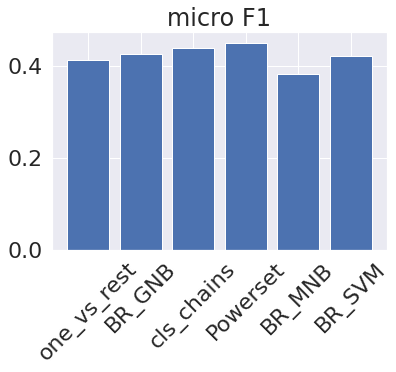

In [66]:
import matplotlib.pyplot as plt
a1 = a[a.type=='all']
plt.bar(a1['model'], a1['f1(micro)']);
plt.xticks(rotation=45);
plt.title('micro F1');

Text(0.5, 1.0, 'macro F1')

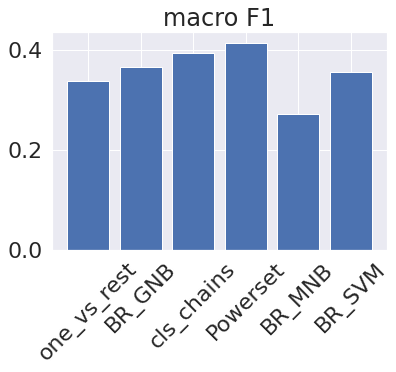

In [67]:
a2 = a[a.type=='multi']
plt.bar(a2['model'], a2['f1(micro)']);
plt.xticks(rotation=45);
plt.title('macro F1')

/home/yibo/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


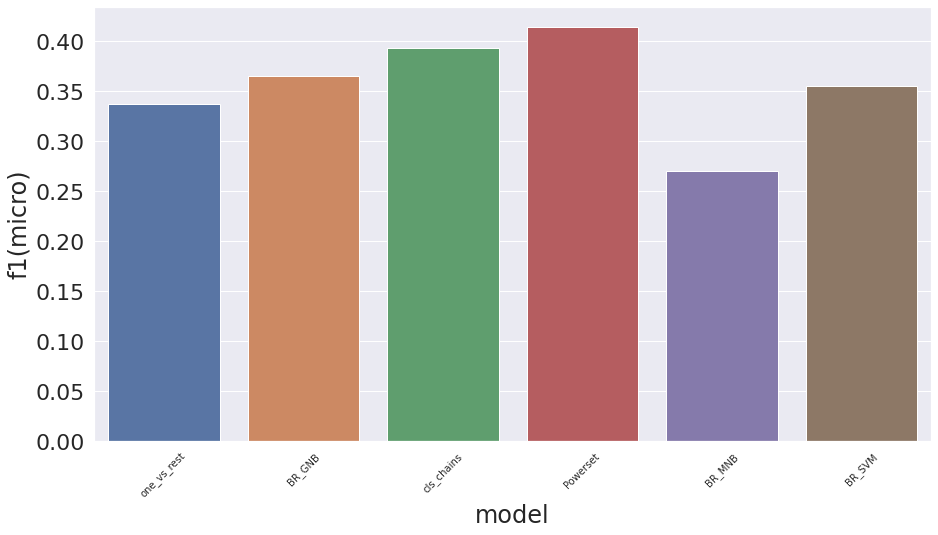

In [68]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(a2['model'], a2['f1(micro)'])

# plt.title("News in each category", fontsize=24)
# plt.ylabel('Number of News', fontsize=18)
# plt.xlabel('Action Type ', fontsize=18)

#adding the text labels
# rects = ax.patches
# labels = data_raw.iloc[:,1:].sum().values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, 
#             height + 5, label, ha='center', va='bottom', fontsize=18)

plt.xticks(rotation=45, fontsize=10)
    
plt.show()
